## HYBRID ARCHITECTURE

In [1]:
import os
import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, AvgPool2D
from tensorflow.keras.layers import Input, Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, AvgPool2D, Dropout, Flatten, Dense, Concatenate




In [2]:
# Image Preprocessing
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
train_data = train_datagen.flow_from_directory('DATASET/TRAIN', target_size=(224, 224), batch_size=32, class_mode='categorical')
test_datagen = ImageDataGenerator(rescale=1./255)
test_data = test_datagen.flow_from_directory('DATASET/TEST', target_size=(224, 224), batch_size=32, class_mode='categorical')



Found 1200 images belonging to 12 classes.
Found 1200 images belonging to 12 classes.


In [3]:
# Pre-trained Model: MobileNet
mobile_base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in mobile_base_model.layers:
    layer.trainable = False

mobile_model = tf.keras.Sequential()
mobile_model.add(mobile_base_model)
mobile_model.add(Flatten())
mobile_model.add(Dense(12, activation='softmax'))

mobile_model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])



In [4]:
# Inception (GoogLeNet)
def googlenet(input_shape, n_classes):
    def inception_block(x, f):
        t1 = Conv2D(f[0], 1, activation='relu')(x)
        t2 = Conv2D(f[1], 1, activation='relu')(x)
        t2 = Conv2D(f[2], 3, padding='same', activation='relu')(t2)
        t3 = Conv2D(f[3], 1, activation='relu')(x)
        t3 = Conv2D(f[4], 5, padding='same', activation='relu')(t3)
        t4 = MaxPool2D(3, 1, padding='same')(x)
        t4 = Conv2D(f[5], 1, activation='relu')(t4)
        output = Concatenate()([t1, t2, t3, t4])
        return output

    input = Input(input_shape)
    x = Conv2D(64, 7, strides=2, padding='same', activation='relu')(input)
    x = MaxPool2D(3, strides=2, padding='same')(x)
    x = Conv2D(64, 1, activation='relu')(x)
    x = Conv2D(192, 3, padding='same', activation='relu')(x)
    x = MaxPool2D(3, strides=2)(x)
    x = inception_block(x, [64, 96, 128, 16, 32, 32])
    x = inception_block(x, [128, 128, 192, 32, 96, 64])
    x = MaxPool2D(3, strides=2, padding='same')(x)
    x = inception_block(x, [192, 96, 208, 16, 48, 64])
    x = inception_block(x, [160, 112, 224, 24, 64, 64])
    x = inception_block(x, [128, 128, 256, 24, 64, 64])
    x = inception_block(x, [112, 144, 288, 32, 64, 64])
    x = inception_block(x, [256, 160, 320, 32, 128, 128])
    x = MaxPool2D(3, strides=2, padding='same')(x)
    x = inception_block(x, [256, 160, 320, 32, 128, 128])
    x = inception_block(x, [384, 192, 384, 48, 128, 128])
    x = AvgPool2D(7, strides=1)(x)
    x = Dropout(0.4)(x)
    x = Flatten()(x)
    output = Dense(n_classes, activation='softmax')(x)
    model = Model(input, output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

googlenet_model = googlenet((224, 224, 3), 12)



In [5]:
# Custom CNN Model (Manual Model)
def manual_model(input_shape):
    model = Sequential()
    model.add(Convolution2D(32, (3, 3), input_shape=input_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(38, activation='relu'))
    model.add(Dense(12, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

manual_model = manual_model((224, 224, 3))




In [6]:
# Model Training and Evaluation
models = [mobile_model, googlenet_model, manual_model]
model_names = ['MobileNet', 'GoogleNet', 'ManualCNN']

history = {}
for i, model in enumerate(models):
    print(f"Training {model_names[i]}...")
    history[model_names[i]] = model.fit(train_data, epochs=10, validation_data=test_data)



Training MobileNet...
Epoch 1/10
38/38 [==============================] - 104s 3s/step - loss: 7.8213 - accuracy: 0.4075 - val_loss: 2.0967 - val_accuracy: 0.7800
Epoch 2/10
38/38 [==============================] - 101s 3s/step - loss: 2.0417 - accuracy: 0.8025 - val_loss: 0.8920 - val_accuracy: 0.8708
Epoch 3/10
38/38 [==============================] - 99s 3s/step - loss: 1.0004 - accuracy: 0.8667 - val_loss: 0.3023 - val_accuracy: 0.9333
Epoch 4/10
38/38 [==============================] - 102s 3s/step - loss: 0.6559 - accuracy: 0.9167 - val_loss: 0.4625 - val_accuracy: 0.9167
Epoch 5/10
38/38 [==============================] - 100s 3s/step - loss: 0.5725 - accuracy: 0.9242 - val_loss: 0.6221 - val_accuracy: 0.9083
Epoch 6/10
38/38 [==============================] - 100s 3s/step - loss: 0.5242 - accuracy: 0.9300 - val_loss: 0.4313 - val_accuracy: 0.9300
Epoch 7/10
38/38 [==============================] - 106s 3s/step - loss: 0.6072 - accuracy: 0.9283 - val_loss: 0.3632 - val_accuracy:

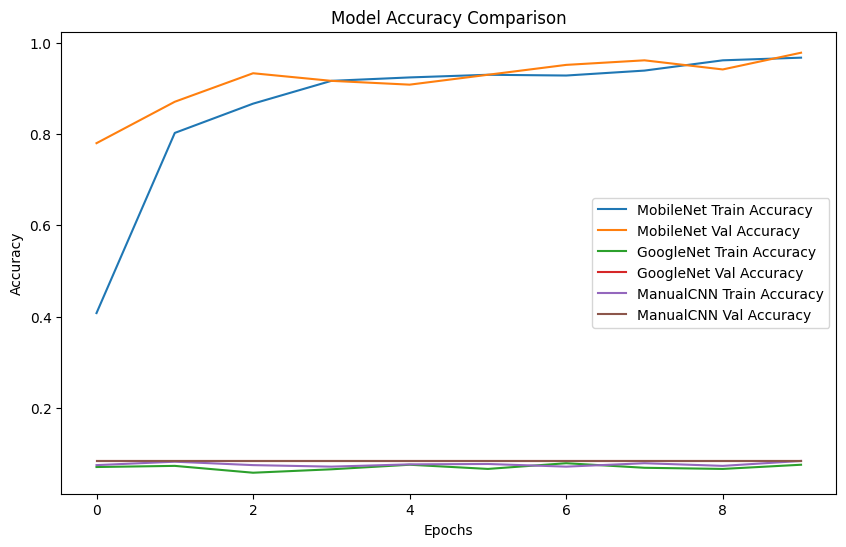

In [7]:
# Plot accuracy comparison
plt.figure(figsize=(10, 6))
for name, h in history.items():
    plt.plot(h.history['accuracy'], label=f'{name} Train Accuracy')
    plt.plot(h.history['val_accuracy'], label=f'{name} Val Accuracy')

plt.title('Model Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()



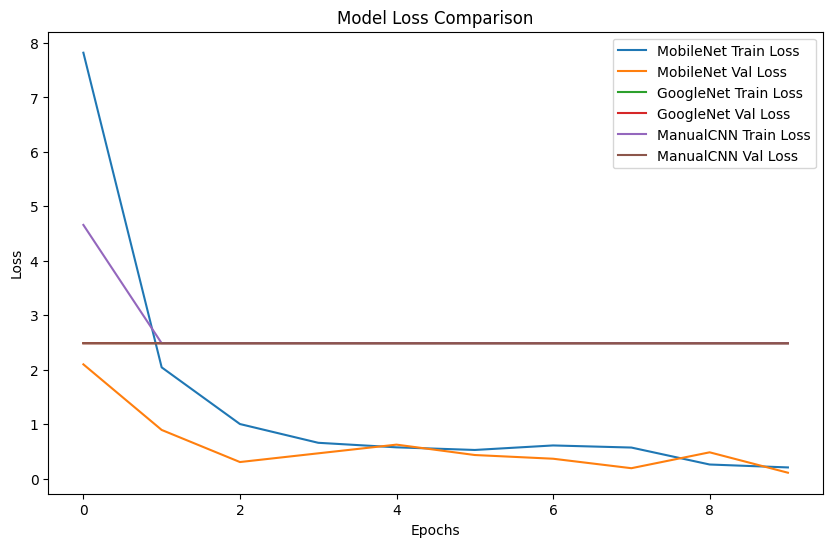

In [8]:
# Plot loss comparison
plt.figure(figsize=(10, 6))
for name, h in history.items():
    plt.plot(h.history['loss'], label=f'{name} Train Loss')
    plt.plot(h.history['val_loss'], label=f'{name} Val Loss')

plt.title('Model Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()



In [10]:
# Ensemble Model: Combining predictions from all models
def ensemble_predict(models, test_data):
    predictions = [model.predict(test_data) for model in models]
    avg_predictions = np.mean(predictions, axis=0)
    return np.argmax(avg_predictions, axis=1)

y_true = test_data.classes
y_pred_ensemble = ensemble_predict(models, test_data)


38/38 [==============================] - 47s 1s/step


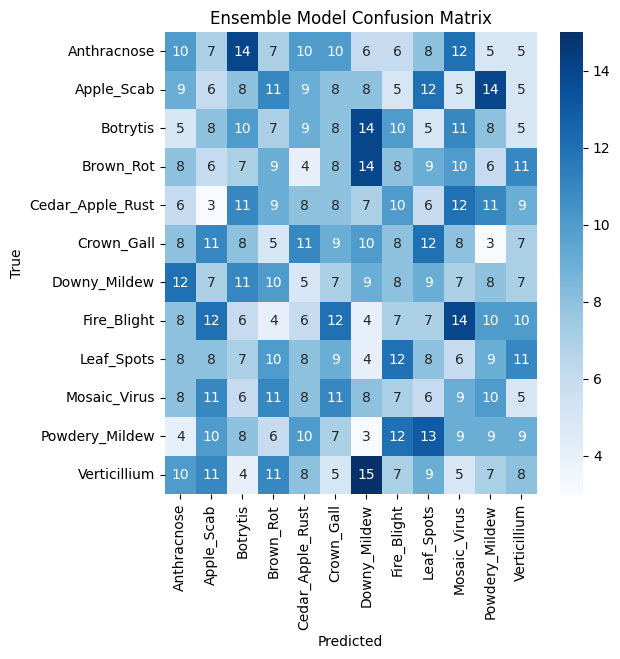

In [11]:

# Confusion Matrix for Ensemble
cm = confusion_matrix(y_true, y_pred_ensemble)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_data.class_indices.keys(), yticklabels=test_data.class_indices.keys())
plt.title('Ensemble Model Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()



In [12]:
# Classification Report for Ensemble Model
cr = classification_report(y_true, y_pred_ensemble, target_names=test_data.class_indices.keys())
print(f"Classification Report for Ensemble Model:\n{cr}")

Classification Report for Ensemble Model:
                  precision    recall  f1-score   support

     Anthracnose       0.10      0.10      0.10       100
      Apple_Scab       0.06      0.06      0.06       100
        Botrytis       0.10      0.10      0.10       100
       Brown_Rot       0.09      0.09      0.09       100
Cedar_Apple_Rust       0.08      0.08      0.08       100
      Crown_Gall       0.09      0.09      0.09       100
    Downy_Mildew       0.09      0.09      0.09       100
     Fire_Blight       0.07      0.07      0.07       100
      Leaf_Spots       0.08      0.08      0.08       100
    Mosaic_Virus       0.08      0.09      0.09       100
  Powdery_Mildew       0.09      0.09      0.09       100
    Verticillium       0.09      0.08      0.08       100

        accuracy                           0.09      1200
       macro avg       0.09      0.08      0.09      1200
    weighted avg       0.09      0.09      0.09      1200



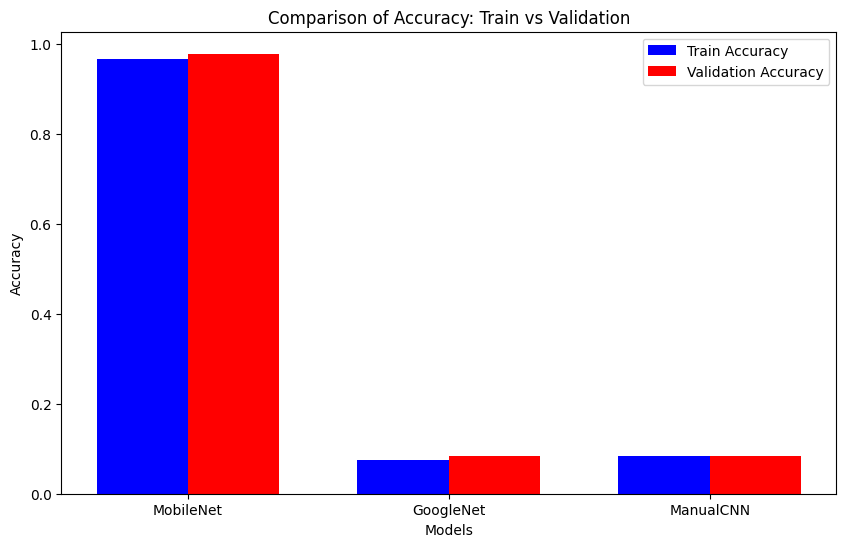

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Extract accuracy values for each model
train_accuracies = [history[model_names[i]].history['accuracy'][-1] for i in range(len(models))]
val_accuracies = [history[model_names[i]].history['val_accuracy'][-1] for i in range(len(models))]

# Set positions for the bars
x = np.arange(len(models))

# Bar width
width = 0.35

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create bars for train and validation accuracies
bar1 = ax.bar(x - width / 2, train_accuracies, width, label='Train Accuracy', color='b')
bar2 = ax.bar(x + width / 2, val_accuracies, width, label='Validation Accuracy', color='r')

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')
ax.set_title('Comparison of Accuracy: Train vs Validation')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend()

# Display the bar chart
plt.show()


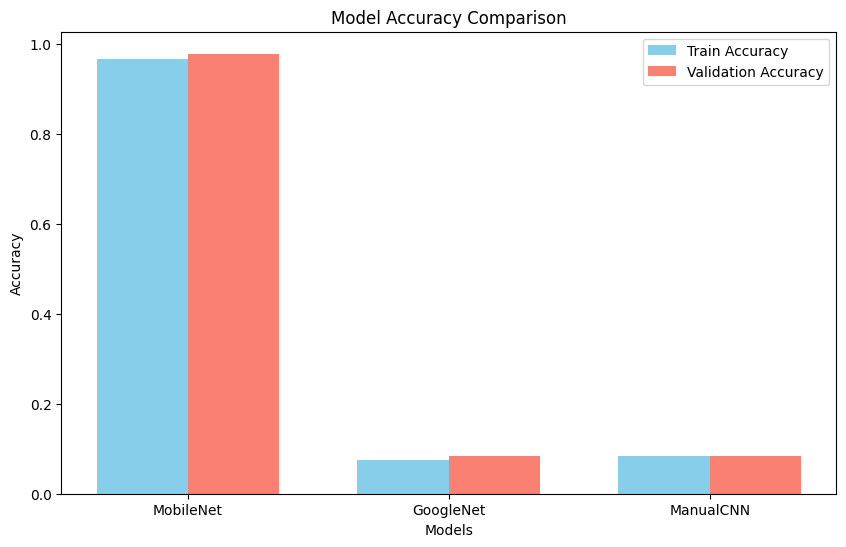

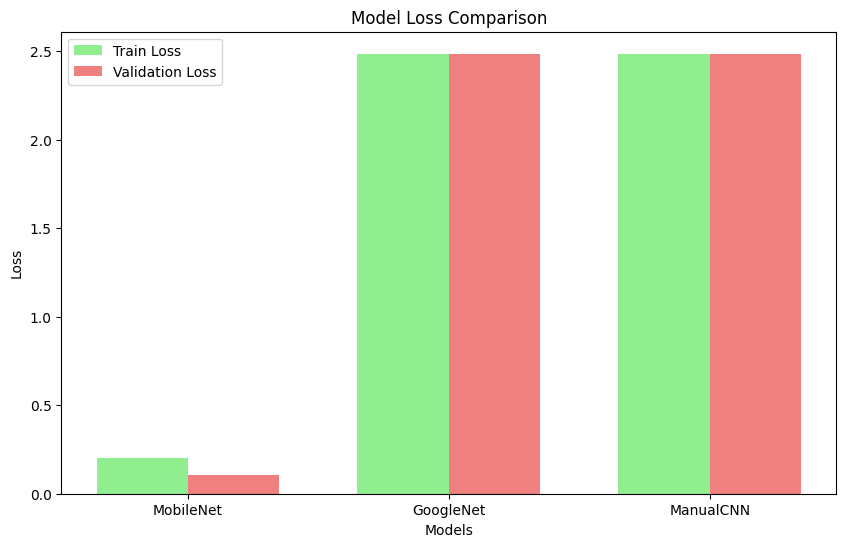

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare metrics data for the bar plot
accuracy_train = [history['MobileNet'].history['accuracy'][-1], history['GoogleNet'].history['accuracy'][-1], history['ManualCNN'].history['accuracy'][-1]]
accuracy_val = [history['MobileNet'].history['val_accuracy'][-1], history['GoogleNet'].history['val_accuracy'][-1], history['ManualCNN'].history['val_accuracy'][-1]]
loss_train = [history['MobileNet'].history['loss'][-1], history['GoogleNet'].history['loss'][-1], history['ManualCNN'].history['loss'][-1]]
loss_val = [history['MobileNet'].history['val_loss'][-1], history['GoogleNet'].history['val_loss'][-1], history['ManualCNN'].history['val_loss'][-1]]

# Set up positions for the bar groups
bar_width = 0.35
index = np.arange(len(model_names))

# Plot Accuracy comparison
plt.figure(figsize=(10, 6))
plt.bar(index, accuracy_train, bar_width, label='Train Accuracy', color='skyblue')
plt.bar(index + bar_width, accuracy_val, bar_width, label='Validation Accuracy', color='salmon')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xticks(index + bar_width / 2, model_names)
plt.legend()
plt.show()

# Plot Loss comparison
plt.figure(figsize=(10, 6))
plt.bar(index, loss_train, bar_width, label='Train Loss', color='lightgreen')
plt.bar(index + bar_width, loss_val, bar_width, label='Validation Loss', color='lightcoral')
plt.xlabel('Models')
plt.ylabel('Loss')
plt.title('Model Loss Comparison')
plt.xticks(index + bar_width / 2, model_names)
plt.legend()
plt.show()
